In [ ]:
# HIDE OUTPUT
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.0 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [ ]:
# HIDE OUTPUT
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
!pip install gym.wrappers
!pip install box2d pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gym.wrappers: filename=gym_wrappers-0.1.0-py3-none-any.whl size=1392 sha256=45ccec8c8bb52cdf280cb821221c25c0c3eb73e0bff88e696af697e78a99328b
  Stored in directory: /root/.cache/pip/wheels/bf/e5/1a/7a9feba5120117a78b2fe42ef373e998ae2dcc068514794768
Successfully built gym.wrappers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.0 MB/s 
     |████████████████████████████████| 21.8 MB 1.5 MB/s 


In [38]:
import numpy as np
import gym
from gym import logger as gymlogger
from IPython.display import HTML
from pyvirtualdisplay import Display
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, GlobalMaxPool2D, BatchNormalization, Dropout, Activation, Rescaling
from keras.regularizers import l2
from keras.backend import clear_session
from gym.wrappers.record_video import RecordVideo
from IPython.display import clear_output

#Image Processing

In [55]:
def image_processing(s, img_len):
    # Convert to grayscale
    s = np.dot(s[...,:3], [0.266, 0.58, 0.1011]).astype(np.uint8)

    # Simplify track part of image
    s[:85, :][s[:85, :]==106.0]=101.0
    s[:85, :][s[:85, :]==104.0]=101.0
    s[:85, :][s[:85, :]==161.0]=255.0
    s[:85, :][s[:85, :]==177.0]=255.0
    s[:85, :][s[:85, :]==254.0]=255.0
    s[:85, :][s[:85, :]==76.0]=255.0

    # Simplify bottom bar of image
    s[86:, :12] = 0.0
    s[86:, :][s[86:, :]==254.0]=255.0
    s[86:, :][s[86:, :]==29.0]=255.0
    s[86:, :][s[86:, :]==44.0]=255.0
    s[86:, :][s[86:, :]==149.0]=255.0
    s[86:, :][s[86:, :]==76.0]=255.0

    # Reshape
    s = np.reshape(s, (1, img_len, img_len))  

    return s


def get_stacked_state(grayscale_state_buffer, frame_interval, img_dim):
    # Create image from grayscale buffer
    img = np.zeros(img_dim)
    for i in range(img_dim[2]):
        img[:, :, i] = grayscale_state_buffer[::-1][i * frame_interval]
    img = np.reshape(img, (1,) + img_dim)

    return img


def plot_rewards(episode_rewards):
    plt.figure(figsize=(8, 6))
    plt.title('DQN Agent')
    plt.plot(episode_rewards, label='Episode reward', alpha=0.5)
    plt.plot([np.mean(episode_rewards[::-1][i:i+100]) for i in range(len(episode_rewards))][::-1], label='Average reward (last 100 episodes)')
    plt.xlabel('episode')
    plt.ylabel('average reward')
    plt.legend()
    plt.show()

In [16]:
class DQNAgent:
    def __init__(self, actions, action_probs, lr, batch_size, gamma):
        print("init")
        self.buffer = deque()
        self.actions = actions
        self.num_actions = self.actions.shape[0]
        self.action_probs = action_probs
        self.lr = lr
        self.batch_size = batch_size
        self.gamma = gamma
        self.model = None
        self.target_model = None

    def cnn_model(self, img_dim):
        model = Sequential()
        model.add(Conv2D(32, 8, activation='relu', strides=4, input_shape=img_dim))
        model.add(Conv2D(64, 4, activation='relu', strides=2))
        model.add(Conv2D(64, 3, activation='relu', strides=1))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.num_actions, activation="linear"))
        opt = Adam(learning_rate=self.lr, epsilon=1e-7, clipnorm=1.0)
        loss_function = keras.losses.Huber()
        model.compile(loss=loss_function, optimizer=opt, metrics=['mean_squared_error'])
        return model


    def create_models(self, img_dim):
        if self.model_path is not None and self.load_model is True:
            self.model = keras.models.load_model(self.model_path)
            self.target_model = keras.models.load_model(self.model_path)
            print("Loaded model")
        else:
            self.model = self.cnn_model(img_dim)
            self.target_model = self.cnn_model(img_dim)



    def experience_replay(self, img_dim, steps):
        batch = random.sample(self.buffer, self.batch_size)

        # Get states adn q values
        s0 = np.array([np.reshape(x[0], img_dim) for x in batch])
        s1 = np.array([np.reshape(x[3], img_dim) for x in batch])
        q0 = self.model.predict(s0)
        q1 = self.target_model.predict(s1)

        for i, (obs0, a, r, obs1, done) in enumerate(batch):
            if done:
                q_new = r
            else: 
                q_new = r + self.gamma * np.max(q1[i])
            q0[i][a] = q_new 

        self.model.fit(s0, q0, epochs=1, batch_size=self.batch_size, verbose = True)        


    def save_model(self, path='./dqn.h5'):
        self.model.save(path)

In [68]:
class Trainer: 
    def __init__(self, number_of_episodes, epsilon, path=None):
        self.img_len = 96
        self.frame_stack_num = 4
        self.frame_interval = 4
        self.img_dim = (96, 96, 4)
        self.number_of_episodes = number_of_episodes
        self.epsilon = epsilon
        self.epsilon_decay_rate = 0.95
        self.max_replay_memory_size = 100000
        self.min_replay_memory_size = 1000
        self.random_action_steps = 5000
        self.update_target_model_steps = 5000
        self.max_steps_per_episode = 10000
        self.action_frames = 4
        self.save_model_frequency = 50
        self.step_count = 0 
        self.grayscale_state_buffer = deque()
        self.episode_rewards = list()
        self.total_avg = list()
        self.path = path


    def train_agent(self, env, agent):
      episode_rewards = list()
      total_avg = list()
      self.step_count = 0
      agent.create_models(self.img_dim)

      for episode_number in range(self.number_of_episodes):
          env.reset()
          # First 50 frames are zooming into track so ignore for training!
          for i in range(0,50):
              s0, _, _, _ = env.step([0.0, 1.0, 0.0])

          # Generate episode
          print(f'Starting episode number {episode_number}')
          episode_reward = self.generate_episode(s0, env, agent, episode_number)
          self.epsilon *= self.epsilon_decay_rate
          episode_rewards.append(episode_reward)
          avg_reward = np.mean(episode_rewards[-100:])
          total_avg.append(avg_reward)

          clear_output(wait=True)
          print(f'Total step count: {self.step_count}')
          print(f'Epsilon: {self.epsilon}')
          print(f'Learning rate: {round(agent.model.optimizer.lr.numpy(), 5)}')
          print(f'Total reward for episode: {episode_reward}')
          print(f'Running average rewards: {np.mean(episode_rewards[-100:])} \n')

          #Plot graph after each episode
          plot_rewards(episode_rewards)

          if episode_number % self.save_model_frequency == 0 and episode_number > 0:
              agent.model.save(f'model_{episode_number}.h5')

      env.close()

      agent.model.save(f'model_final.h5')

      self.episode_rewards = episode_rewards
      self.total_avg = total_avg
    
    def eval_agent(self, env, agent):
      eval_episode_rewards = list()
      eval_total_avg = list()
      self.step_count = 0
      agent.create_models(self.img_dim)
      model = keras.models.load_model(self.path)
      agent.model.set_weights(model.get_weights())
      agent.target_model.set_weights(model.get_weights())

      for episode_number in range(self.number_of_episodes):
          env.reset()
          # First 50 frames are zooming into track so ignore for training!
          for i in range(0,50):
              s0, _, _, _ = env.step([0.0, 1.0, 0.0])

          # Generate episode
          print(f'Starting episode number {episode_number}')
          episode_reward = self.generate_episode_eval(s0, env, agent, episode_number)
          eval_episode_rewards.append(episode_reward)
          avg_reward = np.mean(eval_episode_rewards[-100:])
          eval_total_avg.append(avg_reward)

          clear_output(wait=True)
          print(f'Episode Number: {episode_number}')
          plt.figure(figsize=(8, 6))
          plt.title('Evaluation DQN Agent')
          plt.plot([np.mean(eval_episode_rewards[::-1][i:i+100]) for i in range(len(eval_episode_rewards))][::-1], label='Reward')
          plt.xlabel('Episode')
          plt.ylabel('Reward')
          plt.legend()
          plt.savefig(f'evaluation_rewards.png')
          plt.show()

      env.close()

    def generate_episode_eval(self, s0, env, agent, episode_number=0):
      s0 = env.reset()
      episode_rewards = 0
      s0 = image_processing(s0,self.img_len)
      grayscale_state_buffer = [s0] * self.frame_stack_num * self.frame_interval
      s0_stacked = get_stacked_state(grayscale_state_buffer, self.frame_interval, self.img_dim)

      while True:
          a0 = np.argmax(agent.model.predict(s0_stacked))
          s1, reward, done, _ = env.step(agent.actions[a0])
          episode_rewards += reward
          if done:
              break

          s1 = image_processing(s1, self.img_len)
          grayscale_state_buffer.append(s1)
          s0_stacked = get_stacked_state(grayscale_state_buffer,self.frame_interval, self.img_dim)


      return episode_rewards

    def generate_episode(self, s0, env, agent, episode_number=0):      
      episode_reward = 0
      episode_step_count = 0
      s0 = image_processing(s0, self.img_len)
      grayscale_state_buffer = [s0] * self.frame_stack_num * self.frame_interval
      s0_stacked = get_stacked_state(grayscale_state_buffer, self.frame_interval, self.img_dim)

      while True:
          episode_step_count += 1
          self.step_count += 1

          if np.random.rand() < self.epsilon:
              a0 = np.random.choice(np.arange(agent.num_actions), p=agent.action_probs)
          else:
              a0 = np.argmax(agent.model.predict(s0_stacked))

          action_reward = 0
          for _ in range(self.action_frames):
              s1, reward, done, _ = env.step(agent.actions[a0])
              s1 = image_processing(s1, self.img_len)
              grayscale_state_buffer.pop(0)
              grayscale_state_buffer.append(s1)
              action_reward += reward
              episode_reward += reward
              if done:
                  break

             
          s1_stacked = get_stacked_state(grayscale_state_buffer, self.frame_interval, self.img_dim)
          agent.buffer.append((s0_stacked, a0, action_reward, s1_stacked, done))

          if len(agent.buffer) >= self.min_replay_memory_size:
              agent.experience_replay(self.img_dim, self.step_count, True)

          if len(agent.buffer) > self.max_replay_memory_size:
              agent.buffer.popleft()

          if self.step_count % self.update_target_model_steps == 0:
            agent.target_model.set_weights(agent.model.get_weights())

          
          # End the episode 
          if done or (episode_step_count > self.max_steps_per_episode):
              clear_output(wait=True)
              print(f'Episode: {episode_number}')
              print(f'Total steps in episode: {episode_step_count}')   
              break

          s0_stacked = s1_stacked.copy()

      return episode_reward


    def plot_rewards(self, episode_rewards):
      plt.figure(figsize=(8, 6))
      plt.title('DQN Agent')
      plt.plot(episode_rewards, label='Episode reward', alpha=0.5)
      plt.plot([np.mean(episode_rewards[::-1][i:i+100]) for i in range(len(episode_rewards))][::-1], label='Average reward (last 100 episodes)')
      plt.xlabel('episode')
      plt.ylabel('average reward')
      plt.legend()
      plt.savefig(f'training_rewards.png')
      plt.show()


Total step count: 128677
Epsilon: 0.05
Learning rate: 0.0010000000474974513
Total reward for episode: 298.16779026215715
Running average rewards: 453.32636494185374 



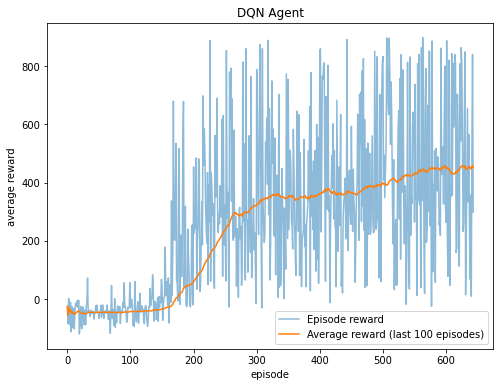

Starting episode number 644
1/1 [==============================] - 0s 19ms/step


In [ ]:
display = Display(visible=0, size=(1400, 900)).start()
actions = np.array([[0.0, 1.0, 0.0],
                    [1.0, 0.0, 0.0],
                    [-1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.8],
                    [0.0, 0.0, 0.0]]   
                )
action_probs = np.array([0.5, 0.125, 0.125, 0.125, 0.125])
dqn_agent = DQNAgent(actions,
                    action_probs,
                    lr=0.001, 
                    batch_size=32,
                    gamma=0.99)
trainer = Trainer(700, 1)
env = RecordVideo(gym.make("CarRacing-v2",verbose=0),'./train_videos/',episode_trigger=lambda x: x % 50 == 0)
trainer.train_agent(env,dqn_agent)


Episode Number: 49


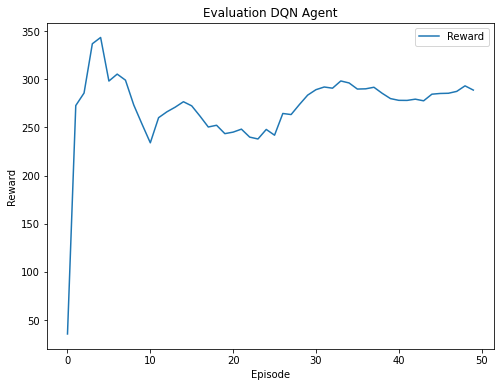

In [70]:
display = Display(visible=0, size=(1400, 900)).start()
actions = np.array([[0.0, 1.0, 0.0],
                    [1.0, 0.0, 0.0],
                    [-1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.8],
                    [0.0, 0.0, 0.0]]   
                )
action_probs = np.array([0.5, 0.125, 0.125, 0.125, 0.125])
dqn_agent = DQNAgent(actions,
                    action_probs,
                    lr=0.001, 
                    batch_size=32,
                    gamma=0.99)
env = RecordVideo(gym.make("CarRacing-v2",verbose=0),'./train_videos/',episode_trigger=lambda x: x % 50 == 0)
trainer = Trainer(50, 0, path = '/content/model_450.h5')
trainer.eval_agent(env,dqn_agent)